In [4]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

In [2]:
!pip install tqdm xgboost

In [5]:
import pandas as pd
import itertools
import xgboost as xgb
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from scipy.special import logit, expit
from datetime import datetime
import os
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import math
import pickle
import json

In [4]:
pd.set_option('max_columns',None)
pd.set_option('display.max_rows', 200)

# Import and prepare data

In [24]:
df = pd.read_pickle('./data/export_features_2016_2020.pkl.bz2')

In [7]:
df_orig = df.copy() # save all data for later

In [8]:
df=df_orig # get all data back

In [25]:
all_features = ['location_count', 'location_mean', 'location_std',
 'location_min', 'location_5%', 'location_10%', 'location_15%',
 'location_20%', 'location_25%', 'location_30%', 'location_35%',
 'location_40%', 'location_45%', 'location_50%', 'location_55%',
 'location_60%', 'location_65%', 'location_70%', 'location_75%',
 'location_80%', 'location_85%', 'location_90%', 'location_95%',
 'location_max', 
                
 'band_count', 'band_mean', 'band_std',
 'band_min', 'band_5%', 'band_10%', 'band_15%', 'band_20%',
 'band_25%', 'band_30%', 'band_35%', 'band_40%', 'band_45%',
 'band_50%', 'band_55%', 'band_60%', 'band_65%', 'band_70%',
 'band_75%', 'band_80%', 'band_85%', 'band_90%', 'band_95%',
 'band_max', 
                
 'promoter_count', 'promoter_mean', 'promoter_std',
 'promoter_min', 'promoter_5%', 'promoter_10%', 'promoter_15%',
 'promoter_20%', 'promoter_25%', 'promoter_30%', 'promoter_35%',
 'promoter_40%', 'promoter_45%', 'promoter_50%', 'promoter_55%',
 'promoter_60%', 'promoter_65%', 'promoter_70%', 'promoter_75%',
 'promoter_80%', 'promoter_85%', 'promoter_90%', 'promoter_95%',
 'promoter_max', 
 
 'vg_datum_year', 'vg_datum_month', 'vg_datum_day_of_week',
                
 'location_kirche',  'location_hotel', 'location_theater', 'location_cafe',
 'location_stadthalle', 'location_buergerhaus', 'location_club', 'location_gaststaette',
 'location_halle', 'location_festhalle', 'location_kurhaus', 'location_schloss',
 'location_restaurant', 'location_kulturzentrum', 'location_festzelt', 'location_musikschule',
 'location_mehrzweckhalle', 'location_pub', 'location_bar', 'location_gasthaus', 'location_turnhalle',
 'location_kulturhaus', 'location_gymnasium', 'location_rathaus', 'location_gasthof',
 'location_park', 'location_kabarett', 'location_schuetzenhalle', 'location_gemeindehalle',
 'location_gemeindehaus', 
                
 'band_musikverein', 'band_band', 'band_mv', 'band_duo', 'band_trio', 'band_musikkapelle',
 'band_chor', 'band_blaskapelle', 'band_orchester', 'band_stadtkapelle', 'band_gbr',
 'band_jazz', 'band_kurorchester', 'band_amp', 'band_ensemble', 'band_blasorchester',
 'band_partyband', 'band_friends', 'band_blues', 'band_original', 'band_live',
 'band_swing', 'band_musikzug', 'band_solo', 'band_mgv', 'band_jugendkapelle',
 'band_sound', 'band_harmonie', 'band_black', 'band_ev']

Add Target Variables for Classifiers

Encode segments for Classifier 1:

    Variable y_clf1
    Positive class (seg 4+) y_clf1=1
    Negative class (seg 2 or 3) y_clf1=0

Encode segments for Classifier 2:

    Variable y_clf2
    Positive class (seg 3) y_clf2=1
    Negative class (seg 2) y_clf2=0
    Segments >3 are "encoded" as np.NaN. These NaN values will be dropped before training


In [26]:
df.loc[:,'y_clf1']=(df.amount_segment.astype(int) > 3).values.astype(int)
df.loc[:,'y_clf2']=df.amount_segment.apply(lambda x: 1 if x==3 else (0 if x==2 else np.nan))

# Get sample of the data

In [ ]:
#Get a sample of the DataFrame 
splitSample = StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=42)

for train_idx, test_idx in splitSample.split(df[all_features], df.amount_segment):
    df_sample=df.iloc[test_idx]
    
    plt.figure()
    df.amount_segment.astype(int).value_counts().sort_index().plot.bar(color='r')
    df_sample.amount_segment.astype(int).value_counts().sort_index().plot.bar(color='g')

    plt.title('Inkasso-Segment')
    plt.legend(['Full DF', 'Sample DF'])
    plt.show()

df=df_sample.copy()
df.info()

# Define Features

In [27]:
feature_groups = ['location', 'band', 'promoter']

feature_group_combinations = []
for i in range(1, len(feature_groups) + 1):
    comb = itertools.combinations(feature_groups, i)
    feature_group_combinations += list(comb)


In [28]:
features={}

features['location'] = ['location_count', 'location_mean', 'location_std',
 'location_min', 'location_5%', 'location_10%', 'location_15%',
 'location_20%', 'location_25%', 'location_30%', 'location_35%',
 'location_40%', 'location_45%', 'location_50%', 'location_55%',
 'location_60%', 'location_65%', 'location_70%', 'location_75%',
 'location_80%', 'location_85%', 'location_90%', 'location_95%',
 'location_max', 'location_kirche',  'location_hotel', 'location_theater', 'location_cafe',
 'location_stadthalle', 'location_buergerhaus', 'location_club', 'location_gaststaette',
 'location_halle', 'location_festhalle', 'location_kurhaus', 'location_schloss',
 'location_restaurant', 'location_kulturzentrum', 'location_festzelt', 'location_musikschule',
 'location_mehrzweckhalle', 'location_pub', 'location_bar', 'location_gasthaus', 'location_turnhalle',
 'location_kulturhaus', 'location_gymnasium', 'location_rathaus', 'location_gasthof',
 'location_park', 'location_kabarett', 'location_schuetzenhalle', 'location_gemeindehalle',
 'location_gemeindehaus']

features['band'] = ['band_count', 'band_mean', 'band_std',
 'band_min', 'band_5%', 'band_10%', 'band_15%', 'band_20%',
 'band_25%', 'band_30%', 'band_35%', 'band_40%', 'band_45%',
 'band_50%', 'band_55%', 'band_60%', 'band_65%', 'band_70%',
 'band_75%', 'band_80%', 'band_85%', 'band_90%', 'band_95%',
 'band_max','band_musikverein', 'band_band', 'band_mv', 'band_duo', 'band_trio', 'band_musikkapelle',
 'band_chor', 'band_blaskapelle', 'band_orchester', 'band_stadtkapelle', 'band_gbr',
 'band_jazz', 'band_kurorchester', 'band_amp', 'band_ensemble', 'band_blasorchester',
 'band_partyband', 'band_friends', 'band_blues', 'band_original', 'band_live',
 'band_swing', 'band_musikzug', 'band_solo', 'band_mgv', 'band_jugendkapelle',
 'band_sound', 'band_harmonie', 'band_black', 'band_ev']

features['promoter']=['promoter_count', 'promoter_mean', 'promoter_std',
 'promoter_min', 'promoter_5%', 'promoter_10%', 'promoter_15%',
 'promoter_20%', 'promoter_25%', 'promoter_30%', 'promoter_35%',
 'promoter_40%', 'promoter_45%', 'promoter_50%', 'promoter_55%',
 'promoter_60%', 'promoter_65%', 'promoter_70%', 'promoter_75%',
 'promoter_80%', 'promoter_85%', 'promoter_90%', 'promoter_95%',
 'promoter_max']
    
features['date']=['vg_datum_year', 'vg_datum_month', 'vg_datum_day_of_week']

In [10]:
model_features={}
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    model_features[model_name] = features['date']
    for feature_group in feature_groups:
        if feature_group in feature_group_combination:
            model_features[model_name]=model_features[model_name]+features[feature_group]

# Helper functions

In [22]:
#save model
def save_model(model_path, model, model_config):
    os.makedirs(model_path, exist_ok=True)
    model.save_model(os.path.join(model_path, 'model')) # use xgboosts own save and load function to ensure compatibility
    with open(os.path.join(model_path, 'model_config.json'), 'w') as fp:
        json.dump(model_config, fp)
    print(f"saved model {model_path}")

#load saved model
def load_model(model_path, model_type):
    if model_type == 'classifier' :
        model = xgb.XGBClassifier()
    elif model_type == 'regression' :
        model = xgb.XGBRegressor()
    model.load_model(os.path.join(model_path, 'model'))
    with open(os.path.join(model_path, 'model_config.json'), 'r') as fp:
        model_config = json.load(fp)
    return model, model_config

# Define Models

Define models for each feature group combination

In [12]:
clf1_models = {}
clf2_models = {}
reg2_models = {}
reg3_models = {}
reg2_logit_models = {}
reg3_logit_models = {}

for feature_group_combination in feature_group_combinations:

    model_name="_".join(feature_group_combination)
    
    clf1_models[model_name]=xgb.XGBClassifier(n_estimators=1100, max_depth=9, use_label_encoder=False, objective='binary:logistic',eval_metric = 'error')
    clf1_models[model_name].set_params(tree_method = 'gpu_hist')
    clf2_models[model_name]=xgb.XGBClassifier(n_estimators=1100, max_depth=9, use_label_encoder=False, objective='binary:logistic',eval_metric = 'error')
    clf2_models[model_name].set_params(tree_method = 'gpu_hist')
    reg2_models[model_name]=xgb.XGBRegressor(n_estimators=700, max_depth=7, min_child_weight=5, objective='reg:squarederror')
    reg2_models[model_name].set_params(tree_method = 'gpu_hist')
    #reg2_logit_models[model_name]=xgb.XGBRegressor(n_estimators=700, max_depth=7, min_child_weight=5, objective='reg:squarederror')
    #reg2_logit_models[model_name].set_params(tree_method = 'gpu_hist')
    reg3_models[model_name]=xgb.XGBRegressor(n_estimators=700, max_depth=7, min_child_weight=5, objective='reg:squarederror')
    reg3_models[model_name].set_params(tree_method = 'gpu_hist')
    #reg3_logit_models[model_name]=xgb.XGBRegressor(n_estimators=700, max_depth=7, min_child_weight=5, objective='reg:squarederror')
    #reg3_logit_models[model_name].set_params(tree_method = 'gpu_hist')

# Load Thresholds

In [13]:
classifier_thresholds_clf1 = {}
classifier_thresholds_clf2 = {}

for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Load Thresholds for {}'.format(model_name))

    classifier_thresholds_clf1[model_name]=pd.read_pickle(('./thresholds/export_thresholds_{}_clf1.pkl.bz2').format(model_name))
    classifier_thresholds_clf2[model_name]=pd.read_pickle(('./thresholds/export_thresholds_{}_clf2.pkl.bz2').format(model_name))

    display(classifier_thresholds_clf1[model_name])
    display(classifier_thresholds_clf2[model_name])

Load Thresholds for location


,max_for_clf1,t_neg_clf1
0,0.01,0.043
1,0.02,0.222
2,0.03,0.372
3,0.04,0.509
4,0.05,0.609
5,0.07,0.740
6,0.09,0.813


,max_for_clf2,t_neg_clf2,max_fdr_clf2,t_pos_clf2
0,0.01,0.023,NaN,NaN
1,0.02,0.144,NaN,NaN
2,0.03,0.290,NaN,NaN
3,0.04,0.422,NaN,NaN
4,0.05,0.525,NaN,NaN
5,0.07,0.677,NaN,NaN
6,0.09,0.772,NaN,NaN
7,NaN,NaN,0.01,0.995
8,NaN,NaN,0.02,0.941
9,NaN,NaN,0.03,0.872


Load Thresholds for band


,max_for_clf1,t_neg_clf1
0,0.01,0.007
1,0.02,0.050
2,0.03,0.129
3,0.04,0.231
4,0.05,0.330
5,0.07,0.529
6,0.09,0.686


,max_for_clf2,t_neg_clf2,max_fdr_clf2,t_pos_clf2
0,0.01,0.001,NaN,NaN
1,0.02,0.020,NaN,NaN
2,0.03,0.068,NaN,NaN
3,0.04,0.145,NaN,NaN
4,0.05,0.244,NaN,NaN
5,0.07,0.459,NaN,NaN
6,0.09,0.657,NaN,NaN
7,NaN,NaN,0.01,1.000
8,NaN,NaN,0.02,0.997
9,NaN,NaN,0.03,0.972


Load Thresholds for promoter


,max_for_clf1,t_neg_clf1
0,0.01,0.017
1,0.02,0.075
2,0.03,0.188
3,0.04,0.331
4,0.05,0.474
5,0.07,0.689
6,0.09,0.815


,max_for_clf2,t_neg_clf2,max_fdr_clf2,t_pos_clf2
0,0.01,0.008,NaN,NaN
1,0.02,0.043,NaN,NaN
2,0.03,0.100,NaN,NaN
3,0.04,0.197,NaN,NaN
4,0.05,0.321,NaN,NaN
5,0.07,0.559,NaN,NaN
6,0.09,0.744,NaN,NaN
7,NaN,NaN,0.01,0.991
8,NaN,NaN,0.02,0.948
9,NaN,NaN,0.03,0.907


Load Thresholds for location_band


,max_for_clf1,t_neg_clf1
0,0.01,0.015
1,0.02,0.090
2,0.03,0.223
3,0.04,0.392
4,0.05,0.560
5,0.07,0.778
6,0.09,0.885


,max_for_clf2,t_neg_clf2,max_fdr_clf2,t_pos_clf2
0,0.01,0.003,NaN,NaN
1,0.02,0.030,NaN,NaN
2,0.03,0.094,NaN,NaN
3,0.04,0.205,NaN,NaN
4,0.05,0.331,NaN,NaN
5,0.07,0.592,NaN,NaN
6,0.09,0.806,NaN,NaN
7,NaN,NaN,0.01,1.000
8,NaN,NaN,0.02,0.990
9,NaN,NaN,0.03,0.964


Load Thresholds for location_promoter


,max_for_clf1,t_neg_clf1
0,0.01,0.058
1,0.02,0.235
2,0.03,0.415
3,0.04,0.575
4,0.05,0.699
5,0.07,0.861
6,0.09,0.916


,max_for_clf2,t_neg_clf2,max_fdr_clf2,t_pos_clf2
0,0.01,0.024,NaN,NaN
1,0.02,0.116,NaN,NaN
2,0.03,0.262,NaN,NaN
3,0.04,0.413,NaN,NaN
4,0.05,0.542,NaN,NaN
5,0.07,0.750,NaN,NaN
6,0.09,0.878,NaN,NaN
7,NaN,NaN,0.01,0.994
8,NaN,NaN,0.02,0.948
9,NaN,NaN,0.03,0.882


Load Thresholds for band_promoter


,max_for_clf1,t_neg_clf1
0,0.01,0.012
1,0.02,0.084
2,0.03,0.215
3,0.04,0.375
4,0.05,0.541
5,0.07,0.778
6,0.09,0.898


,max_for_clf2,t_neg_clf2,max_fdr_clf2,t_pos_clf2
0,0.01,0.004,NaN,NaN
1,0.02,0.032,NaN,NaN
2,0.03,0.087,NaN,NaN
3,0.04,0.173,NaN,NaN
4,0.05,0.303,NaN,NaN
5,0.07,0.590,NaN,NaN
6,0.09,0.810,NaN,NaN
7,NaN,NaN,0.01,0.999
8,NaN,NaN,0.02,0.986
9,NaN,NaN,0.03,0.959


Load Thresholds for location_band_promoter


,max_for_clf1,t_neg_clf1
0,0.01,0.017
1,0.02,0.127
2,0.03,0.333
3,0.04,0.557
4,0.05,0.722
5,0.07,0.899
6,0.09,0.959


,max_for_clf2,t_neg_clf2,max_fdr_clf2,t_pos_clf2
0,0.01,0.005,NaN,NaN
1,0.02,0.044,NaN,NaN
2,0.03,0.138,NaN,NaN
3,0.04,0.281,NaN,NaN
4,0.05,0.437,NaN,NaN
5,0.07,0.745,NaN,NaN
6,0.09,0.909,NaN,NaN
7,NaN,NaN,0.01,0.999
8,NaN,NaN,0.02,0.983
9,NaN,NaN,0.03,0.949


# Train Models

In [ ]:
#Define FOR and FDR
max_for_clf1 = 0.03
max_for_clf2 = 0.05 #False omission rate
max_fdr_clf2 = 0.05 #False discovery rate

for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Generating models for {}'.format(model_name))
    
    train_df=pd.DataFrame()
    train_df=df[model_features[model_name]+['amount','amount_segment','y_clf1','y_clf2']].dropna(subset=model_features[model_name]).copy()
        
    # split in X and y for clf1
    X_train_clf1 = train_df[model_features[model_name]]
    y_train_clf1 = train_df.y_clf1
    
    # train clf1
    clf1_models[model_name].fit(X_train_clf1, y_train_clf1)
    print("CLF1 Train Score: {}".format(clf1_models[model_name].score(X_train_clf1, y_train_clf1)))

    # split in X and y for clf2
    df_train_clf2 = train_df.dropna(subset=['y_clf2'])

    X_train_clf2 = df_train_clf2[model_features[model_name]]
    y_train_clf2 = df_train_clf2.y_clf2
        
    #train clf2
    clf2_models[model_name].fit(X_train_clf2, y_train_clf2)
    print("CLF2 Train Score: {}".format(clf2_models[model_name].score(X_train_clf2, y_train_clf2)))

    
    
    #split in X and y for reg2
    df_train_reg2 = train_df[(train_df['amount_segment']==2) & 
                             (train_df['amount']>=0.00001) & 
                             (train_df['amount']<=49.9999)]
    X_train_reg2 = df_train_reg2[model_features[model_name]]
    y_train_reg2 = (df_train_reg2.amount/50).apply(logit)
    
    # train reg2
    reg2_models[model_name].fit(X_train_reg2, y_train_reg2)
    print("REG2 Train Score: {}".format(reg2_models[model_name].score(X_train_reg2, y_train_reg2)))

    
    #split in X and y for reg3
    df_train_reg3 = train_df[(train_df['amount_segment']==3) & 
                             (train_df['amount']>50) & 
                             (train_df['amount']<=99.9999)]

    X_train_reg3 = df_train_reg3[model_features[model_name]]
    y_train_reg3 = ((df_train_reg3.amount-50)/50).apply(logit)
    
    #train reg3
    reg3_models[model_name].fit(X_train_reg3, y_train_reg3)
    print("REG3 Train Score: {}".format(reg3_models[model_name].score(X_train_reg3, y_train_reg3)))

    
    config={}
    model_path={}
    
    #generate config
    config['clf1']= {
        "model_type": "clf1",
        "model_name": model_name,
        "thresholds": {
            "t_neg": classifier_thresholds_clf1[model_name][classifier_thresholds_clf1[model_name]['max_for_clf1']==max_for_clf1]['t_neg_clf1'].values[0]
        },
        "params": clf1_models[model_name].get_xgb_params(),
        "features": model_features[model_name]
    }  
    config['clf2']= {
        "model_type": "clf2",
        "model_name": model_name,
        "thresholds": {
            "t_neg": classifier_thresholds_clf2[model_name][classifier_thresholds_clf2[model_name]['max_for_clf2']==max_for_clf2]['t_neg_clf2'].values[0],
            "t_pos": classifier_thresholds_clf2[model_name][classifier_thresholds_clf2[model_name]['max_fdr_clf2']==max_fdr_clf2]['t_pos_clf2'].values[0]

        },
        "params": clf2_models[model_name].get_xgb_params(),
        "features": model_features[model_name]
    }  
    config['reg2']= {
        "model_type": "reg2",
        "model_name": model_name,
        "params": reg2_models[model_name].get_xgb_params(),
        "features": model_features[model_name]
    }  
    config['reg3']= {
        "model_type": "reg3",
        "model_name": model_name,
        "params": reg3_models[model_name].get_xgb_params(),
        "features": model_features[model_name]
    }  
    
    #generate model paths
    model_path['clf1'] = f'models/'+str(datetime.now().strftime('%Y-%m-%d'))+'/clf1/'+"_".join(sorted(feature_group_combination))
    model_path['clf2'] = f'models/'+str(datetime.now().strftime('%Y-%m-%d'))+'/clf2/'+"_".join(sorted(feature_group_combination))
    model_path['reg2'] = f'models/'+str(datetime.now().strftime('%Y-%m-%d'))+'/reg2/'+"_".join(sorted(feature_group_combination))
    model_path['reg3'] = f'models/'+str(datetime.now().strftime('%Y-%m-%d'))+'/reg3/'+"_".join(sorted(feature_group_combination))
    
    #save models
    save_model(model_path['clf1'], clf1_models[model_name], config['clf1'])
    save_model(model_path['clf2'], clf2_models[model_name], config['clf2'])
    save_model(model_path['reg2'], reg2_models[model_name], config['reg2'])
    save_model(model_path['reg3'], reg3_models[model_name], config['reg3'])

Generating models for location
CLF1 Train Score: 0.9835815097423478
CLF2 Train Score: 0.9820941230830579
REG2 Train Score: 0.7658397516143463
REG3 Train Score: 0.7413243203718962
saved model models/clf1/location_2021-07-17_06-22-09
saved model models/clf2/location_2021-07-17_06-22-09
saved model models/reg2/location_2021-07-17_06-22-09
saved model models/reg3/location_2021-07-17_06-22-09
Generating models for band
CLF1 Train Score: 0.9850127216719158
CLF2 Train Score: 0.9887418759536808
REG2 Train Score: 0.7625266295311126
REG3 Train Score: 0.7721583777464374
saved model models/clf1/band_2021-07-17_06-25-45
saved model models/clf2/band_2021-07-17_06-25-45
saved model models/reg2/band_2021-07-17_06-25-45
saved model models/reg3/band_2021-07-17_06-25-45
Generating models for promoter
CLF1 Train Score: 0.9852840544076881
CLF2 Train Score: 0.9825039928814474
REG2 Train Score: 0.7952425392350824
REG3 Train Score: 0.7811854708145675
saved model models/clf1/promoter_2021-07-17_06-29-14
saved 

# Load Models

models/2021-07-17/clf1/location
location model Train Accuracy Score = 0.9835815097423478


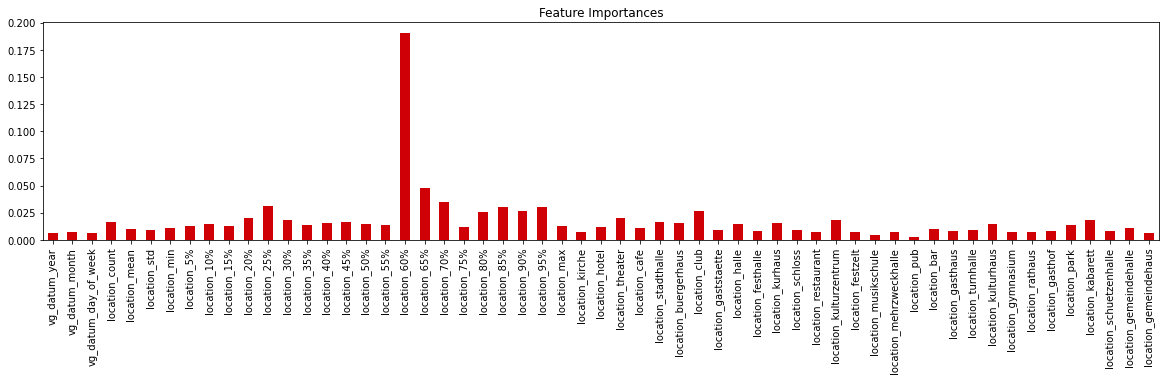

models/2021-07-17/clf2/location
location model Train Accuracy Score = 0.9820941230830579


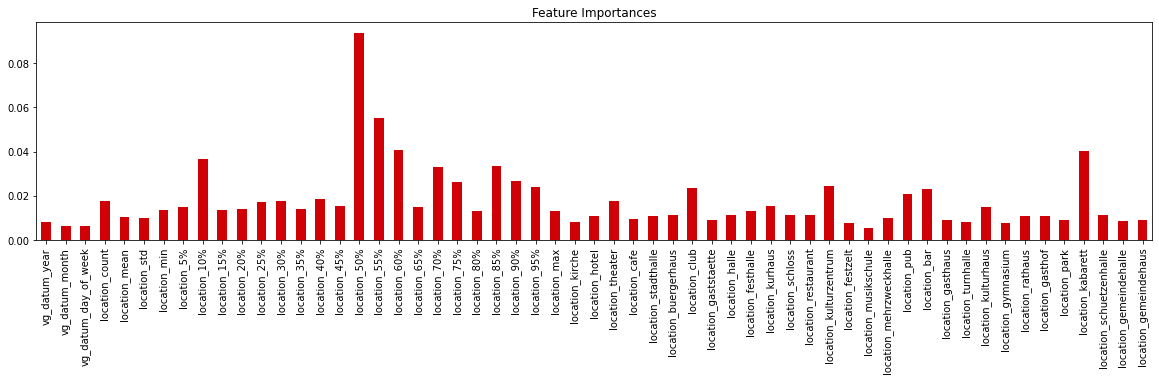

models/2021-07-17/clf1/band
band model Train Accuracy Score = 0.9850127216719158


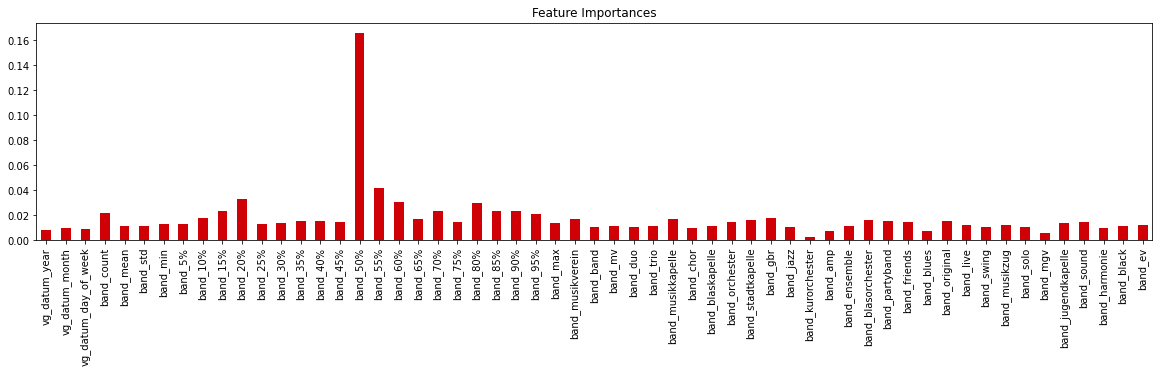

models/2021-07-17/clf2/band
band model Train Accuracy Score = 0.9887418759536808


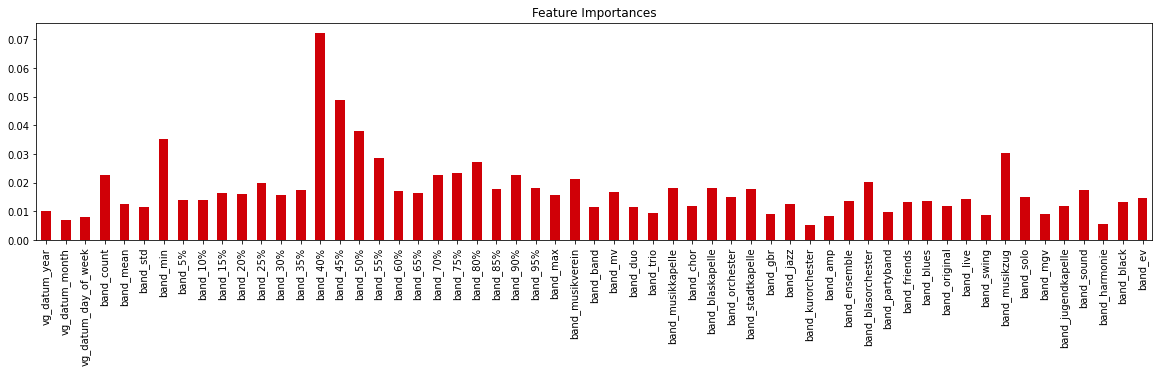

models/2021-07-17/clf1/promoter
promoter model Train Accuracy Score = 0.9852840544076881


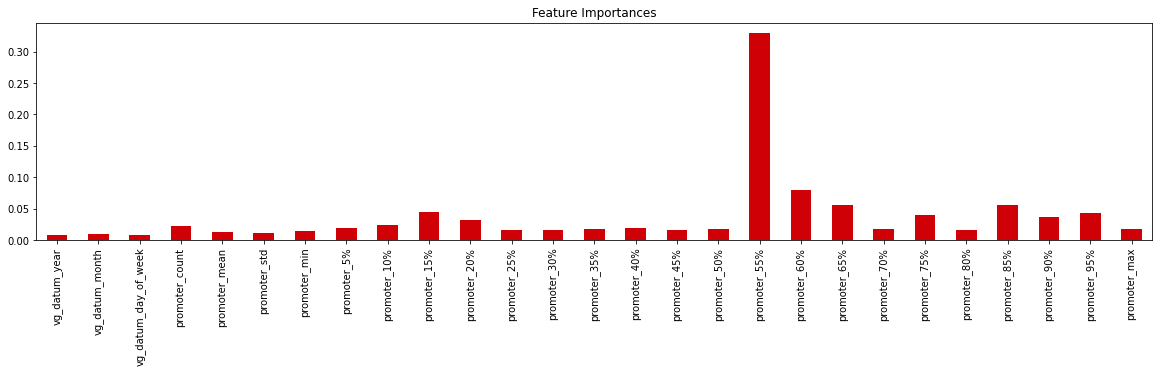

models/2021-07-17/clf2/promoter
promoter model Train Accuracy Score = 0.9825039928814474


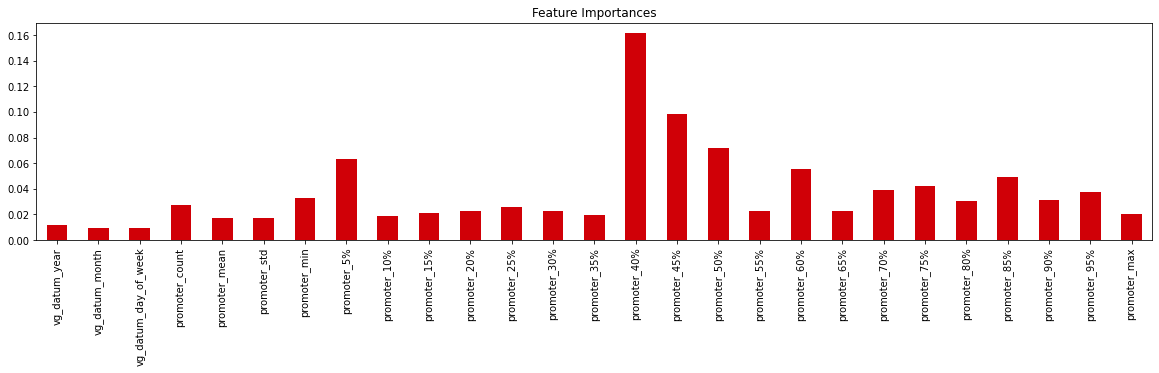

models/2021-07-17/clf1/band_location
band_location model Train Accuracy Score = 0.9991960168560992


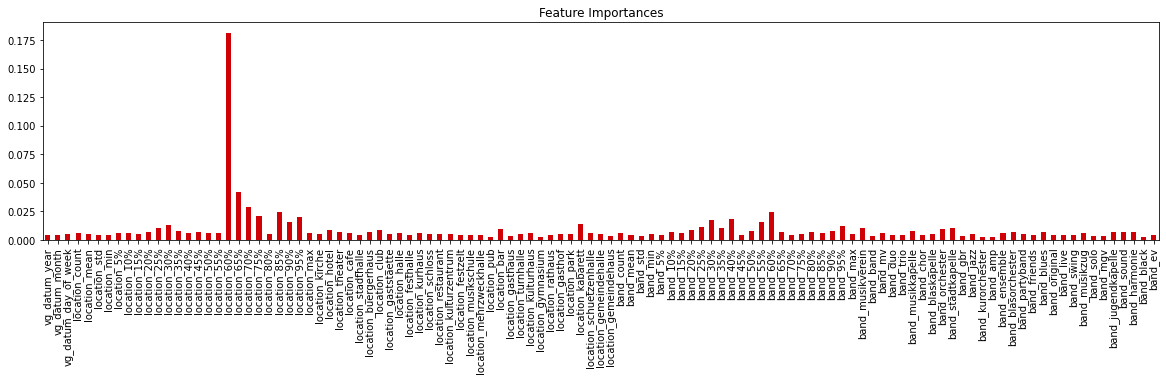

models/2021-07-17/clf2/band_location
band_location model Train Accuracy Score = 0.9995499688949089


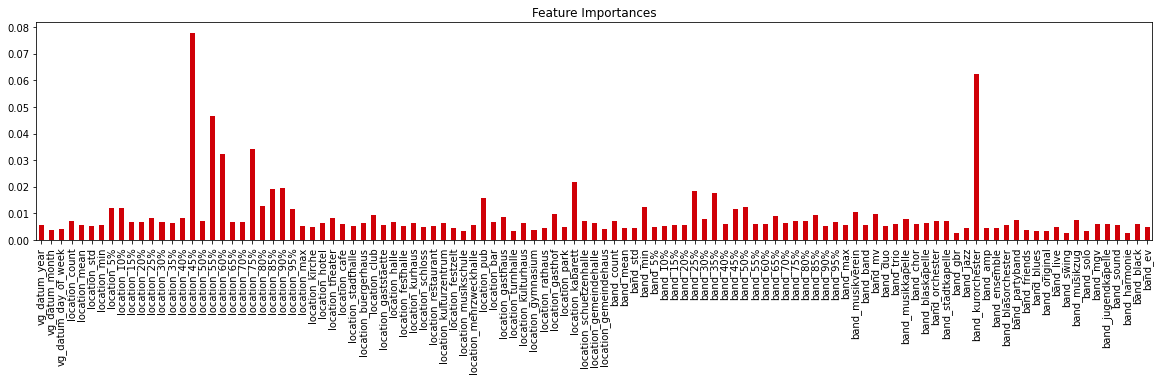

models/2021-07-17/clf1/location_promoter
location_promoter model Train Accuracy Score = 0.9962409722579848


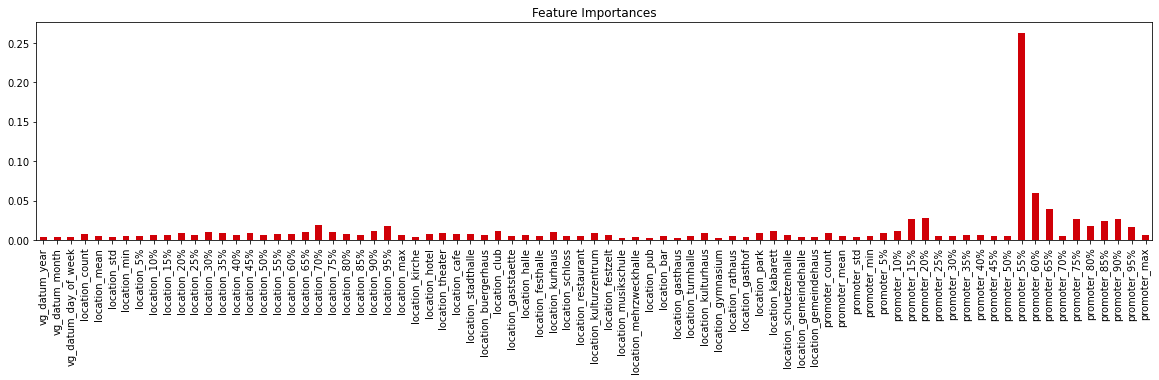

models/2021-07-17/clf2/location_promoter
location_promoter model Train Accuracy Score = 0.9957113147220025


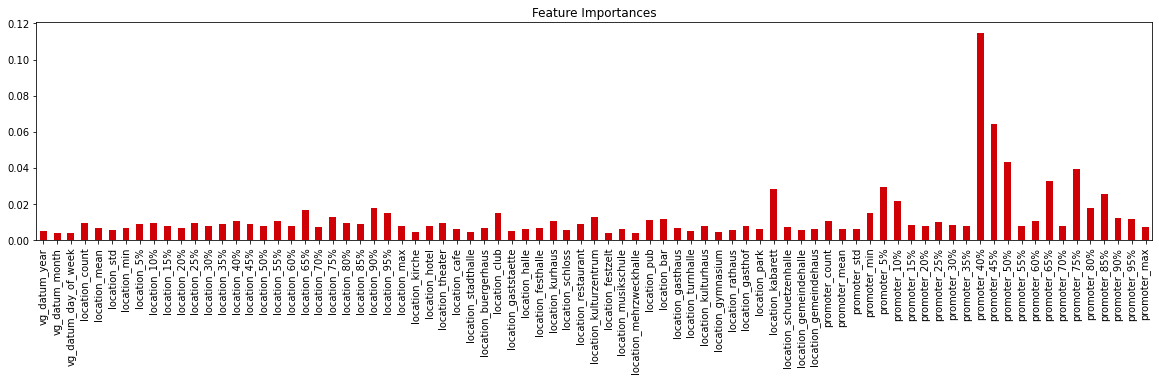

models/2021-07-17/clf1/band_promoter
band_promoter model Train Accuracy Score = 0.9994507160005316


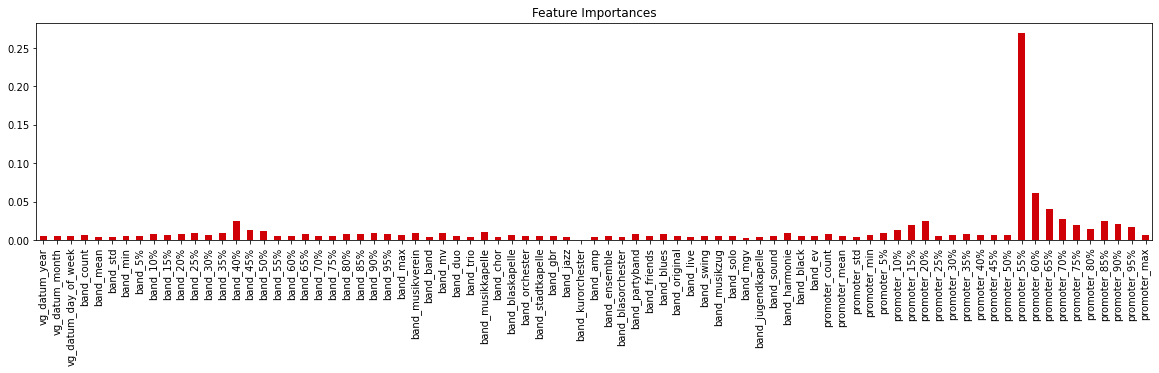

models/2021-07-17/clf2/band_promoter
band_promoter model Train Accuracy Score = 0.9992118627584353


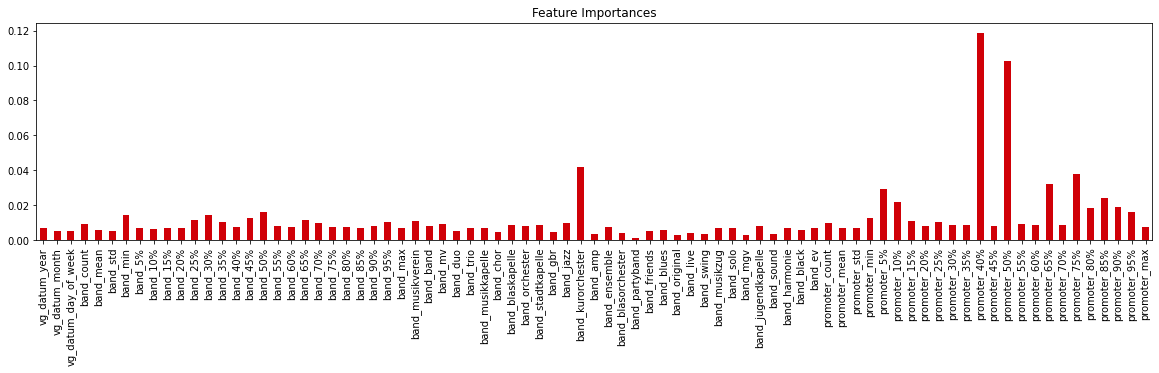

models/2021-07-17/clf1/band_location_promoter
band_location_promoter model Train Accuracy Score = 0.9998757198990952


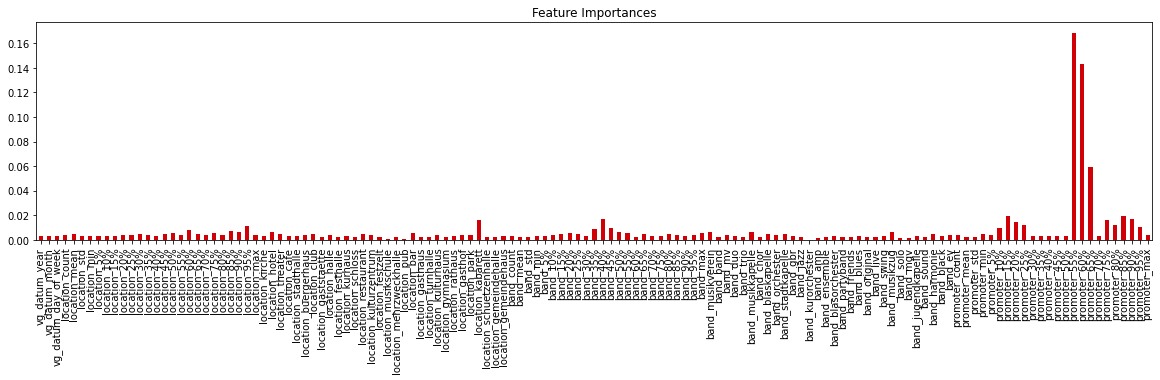

models/2021-07-17/clf2/band_location_promoter
band_location_promoter model Train Accuracy Score = 0.9997845795425792


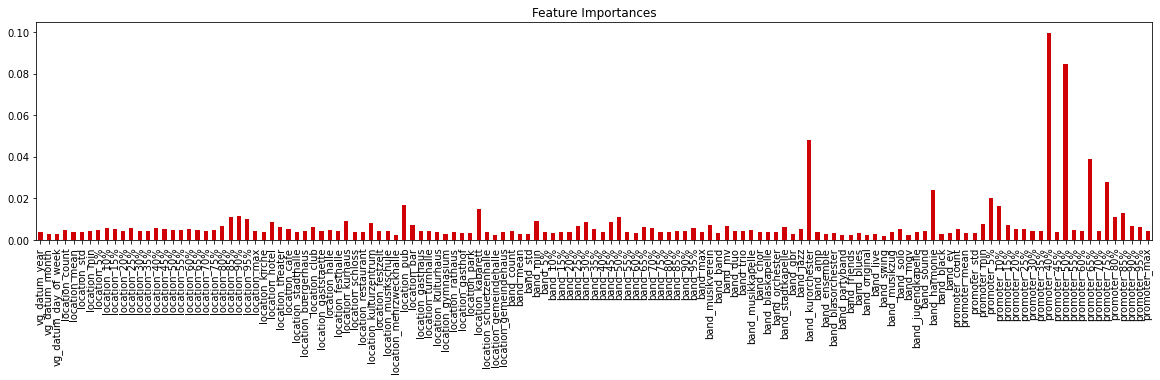

models/2021-07-17/reg2/location
location model Train R2 Score = 0.7840788167073546
location model Train MSE Score = 23.94877924874885


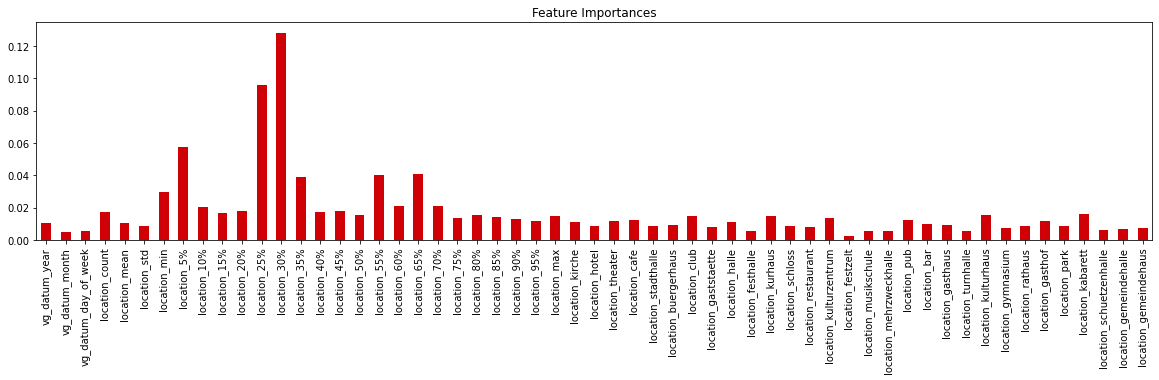

models/2021-07-17/reg3/location
location model Train R2 Score = 0.7632471661974354
location model Train MSE Score = 43.22855812954984


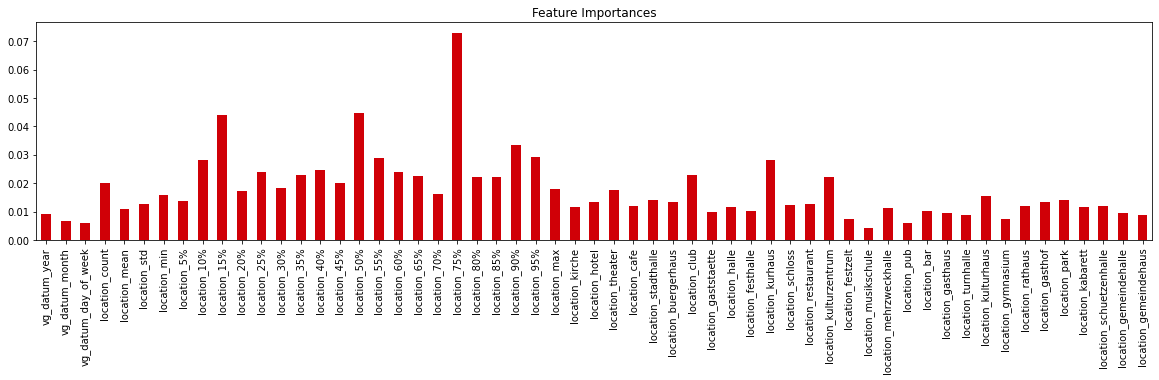

models/2021-07-17/reg2/band
band model Train R2 Score = 0.7767588314917623
band model Train MSE Score = 23.65992165496248


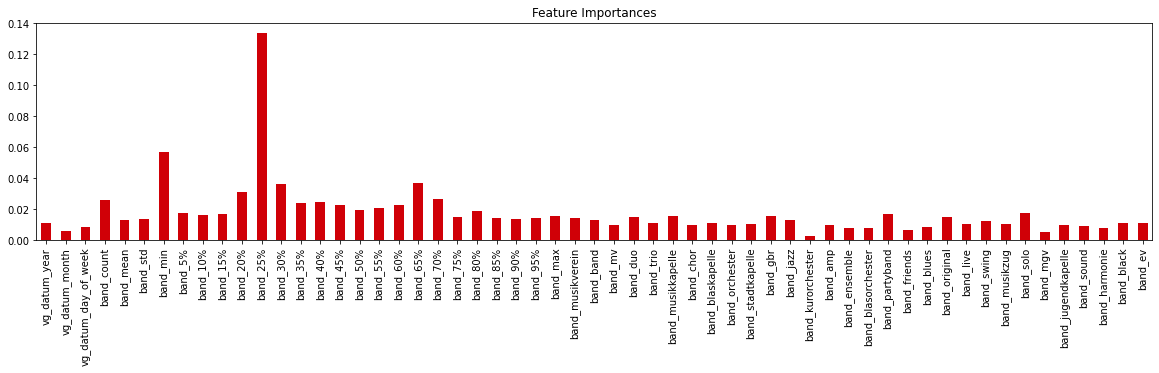

models/2021-07-17/reg3/band
band model Train R2 Score = 0.7964336338071298
band model Train MSE Score = 37.413112818848965


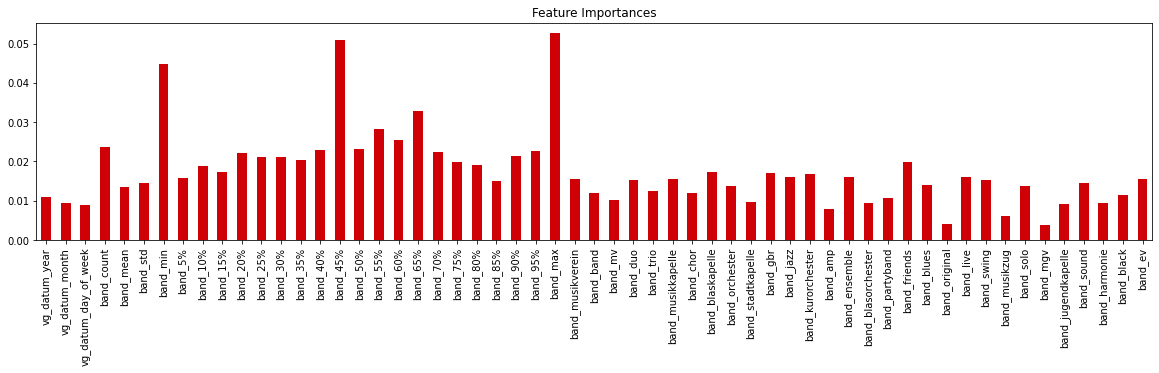

models/2021-07-17/reg2/promoter
promoter model Train R2 Score = 0.8118386226420354
promoter model Train MSE Score = 20.725342121517794


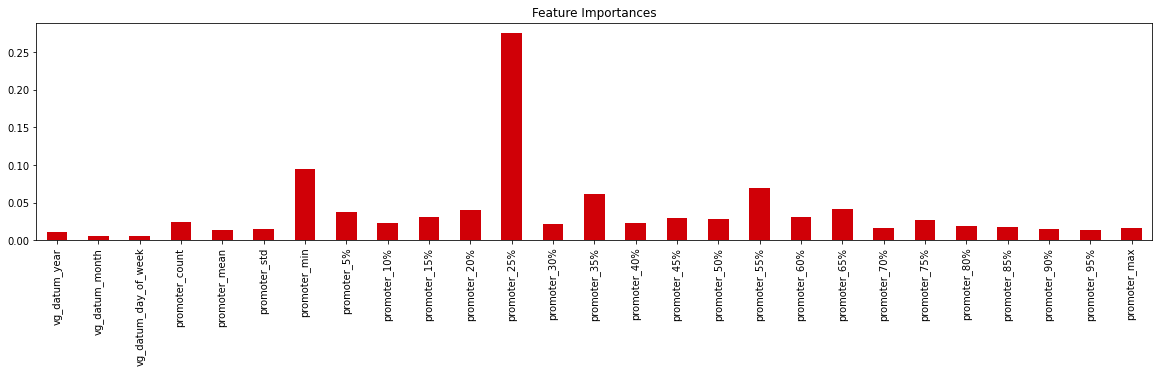

models/2021-07-17/reg3/promoter
promoter model Train R2 Score = 0.8018439041747615
promoter model Train MSE Score = 36.30859269083942


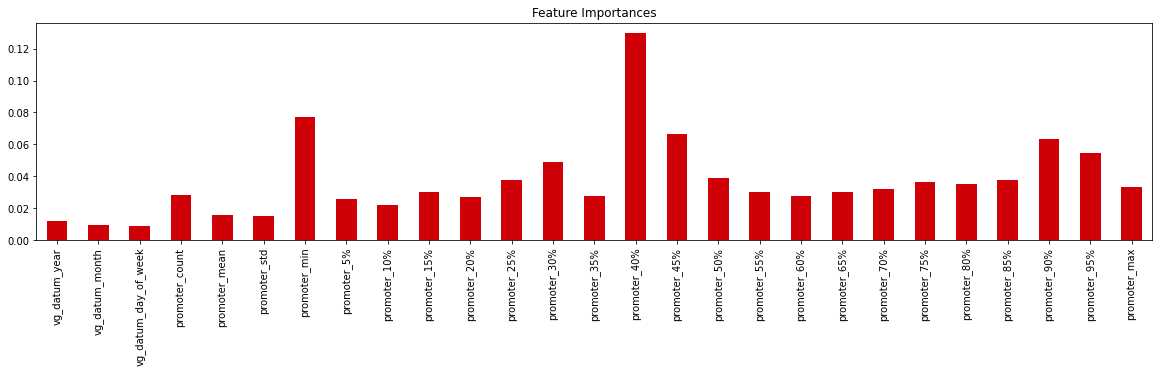

models/2021-07-17/reg2/band_location
band_location model Train R2 Score = 0.8643735816005786
band_location model Train MSE Score = 14.414803053345912


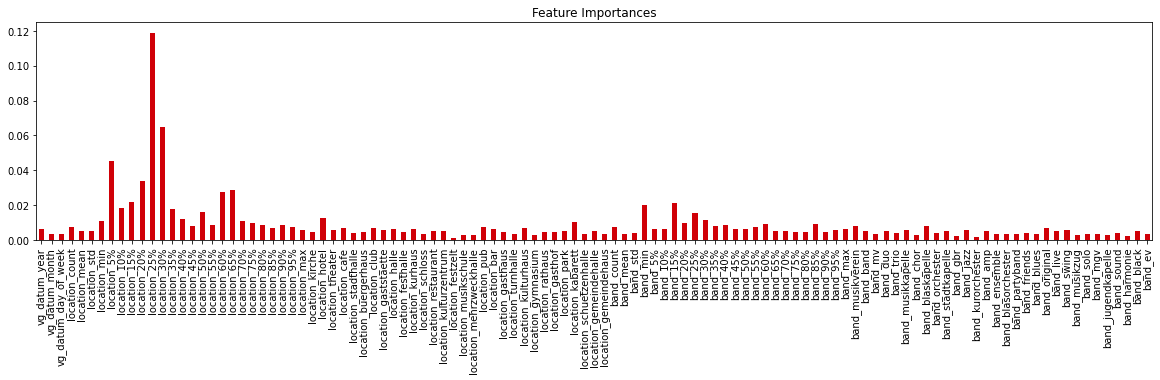

models/2021-07-17/reg3/band_location
band_location model Train R2 Score = 0.8754248917569067
band_location model Train MSE Score = 22.923588949948098


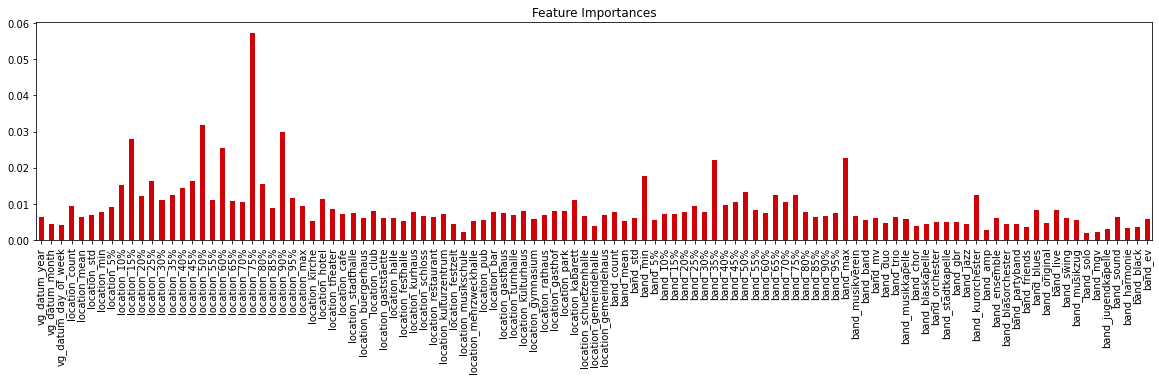

models/2021-07-17/reg2/location_promoter
location_promoter model Train R2 Score = 0.8559903906309071
location_promoter model Train MSE Score = 15.89682367346385


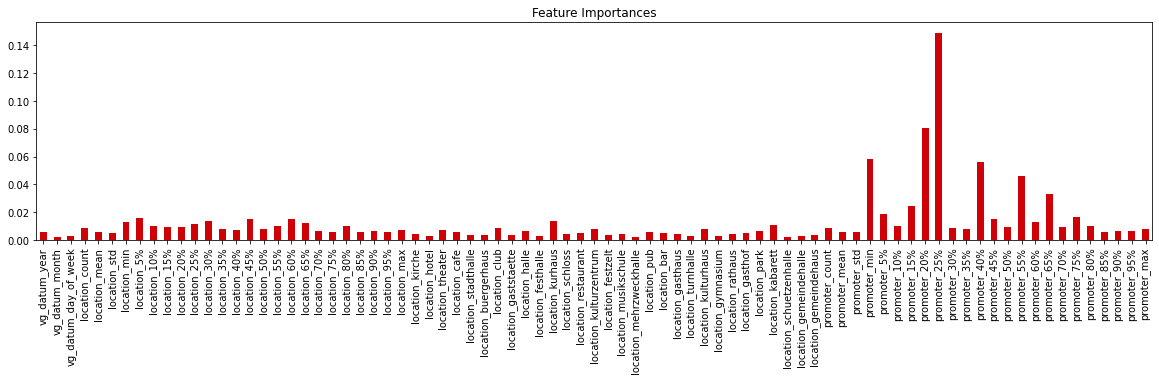

models/2021-07-17/reg3/location_promoter
location_promoter model Train R2 Score = 0.8498095251684936
location_promoter model Train MSE Score = 27.532775513666188


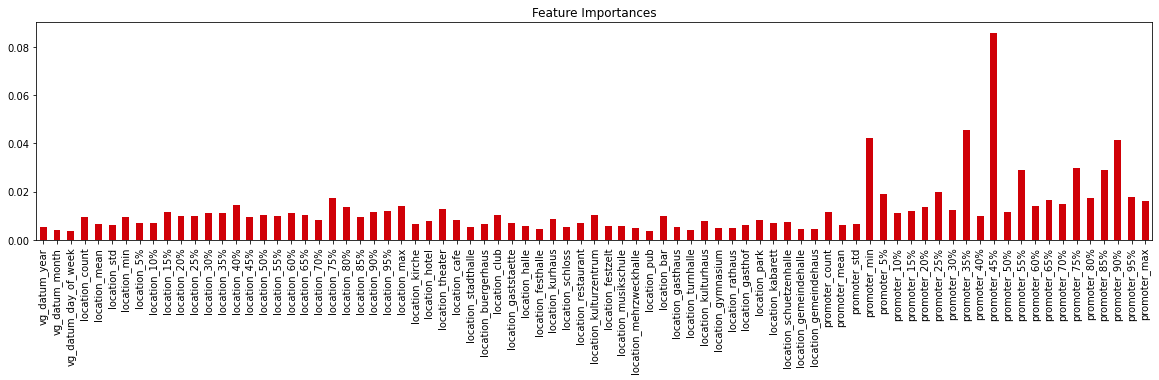

models/2021-07-17/reg2/band_promoter
band_promoter model Train R2 Score = 0.8767577500291599
band_promoter model Train MSE Score = 12.988053487547186


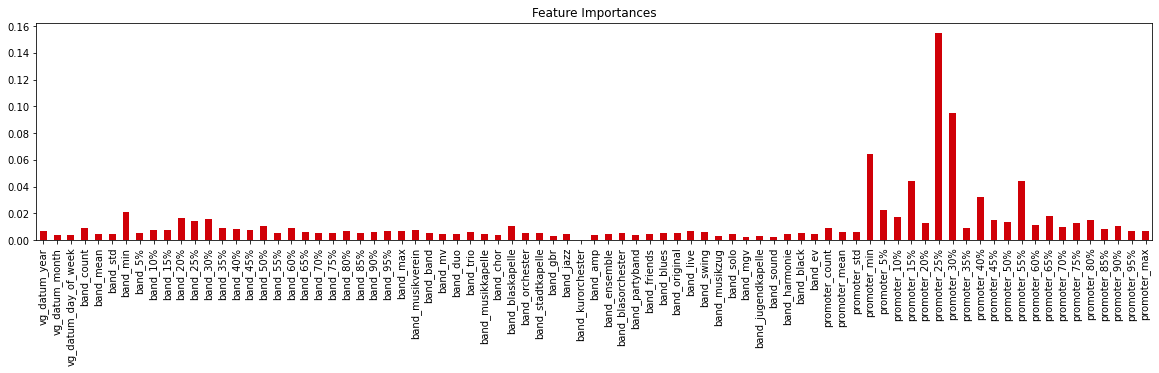

models/2021-07-17/reg3/band_promoter
band_promoter model Train R2 Score = 0.8964908401253673
band_promoter model Train MSE Score = 19.102340219103883


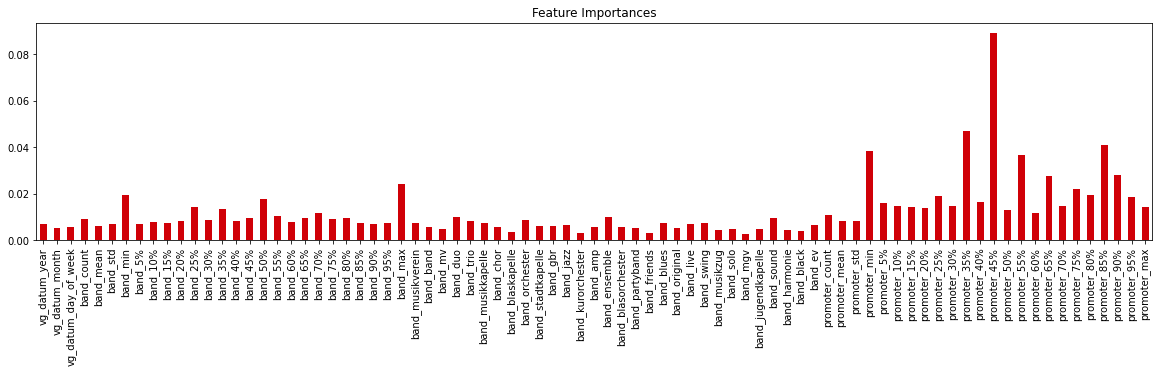

models/2021-07-17/reg2/band_location_promoter
band_location_promoter model Train R2 Score = 0.900156939354086
band_location_promoter model Train MSE Score = 10.542637344221395


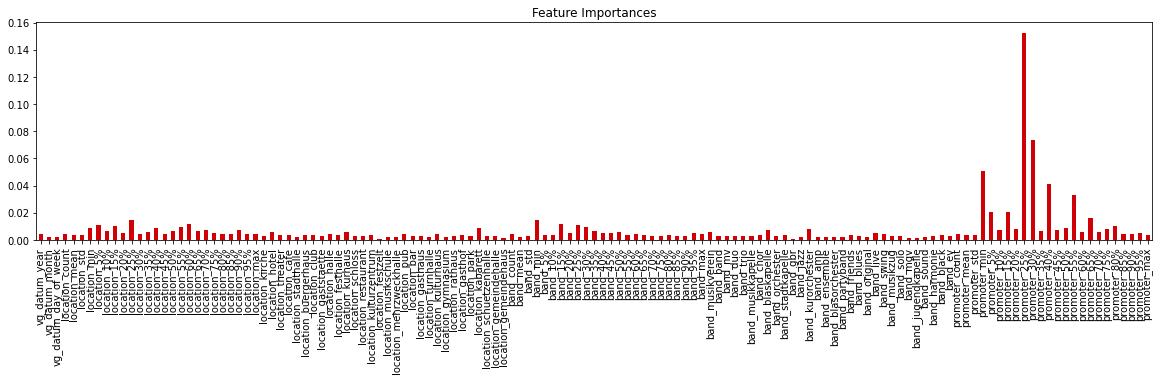

models/2021-07-17/reg3/band_location_promoter
band_location_promoter model Train R2 Score = 0.9161356178310716
band_location_promoter model Train MSE Score = 15.484201411768673


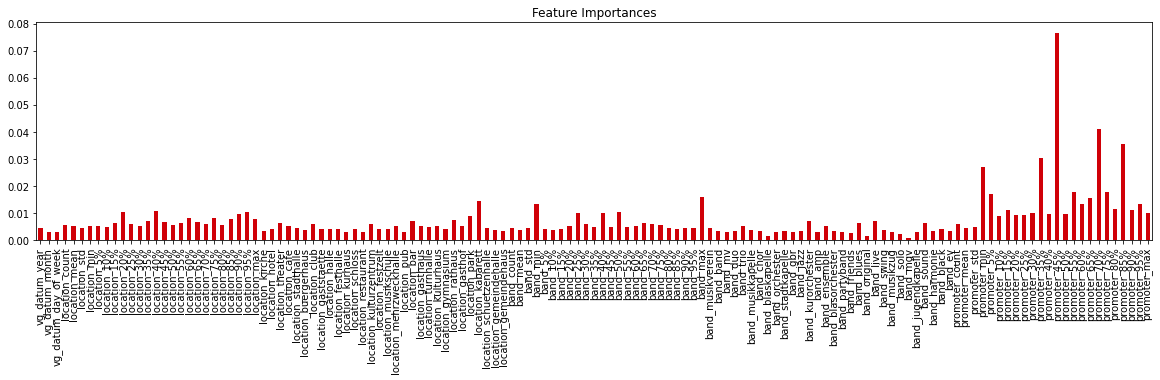

In [29]:
model_paths_clf=[
    f'models/2021-07-17/clf1/location',
    f'models/2021-07-17/clf2/location',
    f'models/2021-07-17/clf1/band',
    f'models/2021-07-17/clf2/band',
    f'models/2021-07-17/clf1/promoter',
    f'models/2021-07-17/clf2/promoter',
    f'models/2021-07-17/clf1/band_location',
    f'models/2021-07-17/clf2/band_location',
    f'models/2021-07-17/clf1/location_promoter',
    f'models/2021-07-17/clf2/location_promoter',
    f'models/2021-07-17/clf1/band_promoter',
    f'models/2021-07-17/clf2/band_promoter',
    f'models/2021-07-17/clf1/band_location_promoter',
    f'models/2021-07-17/clf2/band_location_promoter'
]

model_paths_reg=[
    f'models/2021-07-17/reg2/location',
    f'models/2021-07-17/reg3/location',
    f'models/2021-07-17/reg2/band',
    f'models/2021-07-17/reg3/band',
    f'models/2021-07-17/reg2/promoter',
    f'models/2021-07-17/reg3/promoter',
    f'models/2021-07-17/reg2/band_location',
    f'models/2021-07-17/reg3/band_location',
    f'models/2021-07-17/reg2/location_promoter',
    f'models/2021-07-17/reg3/location_promoter',
    f'models/2021-07-17/reg2/band_promoter',
    f'models/2021-07-17/reg3/band_promoter',
    f'models/2021-07-17/reg2/band_location_promoter',
    f'models/2021-07-17/reg3/band_location_promoter'
]

t_neg_clf1={}
t_neg_clf2={}
t_pos_clf2={}

clf1_models={}
clf2_models={}
reg2_models={}
reg3_models={}

for model_path in model_paths_clf:
    print(model_path)
    clf, config = load_model(model_path, 'classifier')
    model_name=config['model_name']

    #print(config)
      
    if config['model_type']=='clf1':
        test_df = df.dropna(subset=config['features']).copy() 
        X = test_df[config['features']]
        y = test_df.y_clf1
        t_neg_clf1[model_name]=config['thresholds']['t_neg']
        clf1_models[model_name]=clf
    elif config['model_type']=='clf2':
        test_df = df.dropna(subset=config['features']+['y_clf2']).copy() 
        X = test_df[config['features']]
        y = test_df.y_clf2
        t_neg_clf2[model_name]=config['thresholds']['t_neg']
        t_pos_clf2[model_name]=config['thresholds']['t_pos']
        clf2_models[model_name]=clf

    y_pred = clf.predict(X)
    
    print("{} model Train Accuracy Score = {}".format(model_name, accuracy_score(y, y_pred)))
        
    pd.Series(clf.feature_importances_,
          index=config['features']).plot.bar(figsize=(20, 4), color='#d00007')
    plt.title('Feature Importances')
    plt.show()
    
for model_path in model_paths_reg:
    print(model_path)
    reg, config = load_model(model_path, 'regression')
    model_name=config['model_name']

    #print(config)

    if config['model_type']=='reg2':
        test_df = df[(df['amount_segment']==2) & 
                    (df['amount']>0) & 
                    (df['amount']<=50)].dropna(subset=config['features']).copy()
        X = test_df[config['features']]
        y = test_df.amount
        reg2_models[model_name]=reg
    elif config['model_type']=='reg3':
        test_df = df[(df['amount_segment']==3) & 
                    (df['amount']>50) & 
                    (df['amount']<=100)].dropna(subset=config['features']).copy()
        X = test_df[config['features']]
        y = test_df.amount
        reg3_models[model_name]=reg

    y_pred = reg.predict(X)
    
    if config['model_type']=='reg2':
        y_pred = pd.Series(y_pred).apply(expit)*50
    elif config['model_type']=='reg3':
        y_pred = pd.Series(y_pred).apply(expit)*50+50

    print("{} model Train R2 Score = {}".format(model_name, r2_score(y, y_pred)))
    print("{} model Train MSE Score = {}".format(model_name, mean_squared_error(y, y_pred)))
        
    pd.Series(reg.feature_importances_,
          index=config['features']).plot.bar(figsize=(20, 4), color='#d00007')
    plt.title('Feature Importances')
    plt.show()

# The function

In [16]:
def make_predict(df_features, clf1, clf2, reg1, reg2, t_neg1, t_neg2, t_pos2):
    prediction_result=pd.DataFrame(columns=['y_pred_proba_clf1',
                                           'y_pred_proba_clf2',
                                           'y_pred_clf1',
                                           'y_pred_clf2',
                                            'y_pred_reg2',
                                            'y_pred_reg3',
                                           'segment',
                                           'amount'])

    y_pred_proba_clf1 = clf1.predict_proba(df_features)[:, 1]
    y_pred_proba_clf2 = clf2.predict_proba(df_features)[:, 1]
    y_pred_reg2_logit=reg2.predict(df_features)
    y_pred_reg3_logit=reg3.predict(df_features)
    
    prediction_result.y_pred_proba_clf1=y_pred_proba_clf1
    prediction_result.y_pred_proba_clf2=y_pred_proba_clf2
    prediction_result.y_pred_reg2 = pd.Series(y_pred_reg2_logit).apply(expit)*50
    prediction_result.y_pred_reg3 = pd.Series(y_pred_reg3_logit).apply(expit)*50+50
    
    prediction_result['y_pred_proba_clf1']=prediction_result['y_pred_proba_clf1'].apply(lambda x: format(float(x),".8f")).astype(float)
    prediction_result['y_pred_proba_clf2']=prediction_result['y_pred_proba_clf2'].apply(lambda x: format(float(x),".8f")).astype(float)
    
    prediction_result['y_pred_clf1']=prediction_result['y_pred_proba_clf1'].apply(lambda x: '2 or 3' if x <= t_neg1 else '4+')
    prediction_result['y_pred_clf2']=prediction_result['y_pred_proba_clf2'].apply(lambda x: '2' if x<=t_neg2 else 
                                                ('2?' if x<=0.5 else 
                                                 ('3?' if x<=t_pos2 else '3')))
    
    prediction_result['pred_segment']=prediction_result.apply(lambda x: x['y_pred_clf1'] if x['y_pred_clf1']=='4+' else x['y_pred_clf2'], axis=1)

    prediction_result['pred_amount']=prediction_result.apply(lambda x: 
                                                        x['y_pred_reg2'] if '2' in x.pred_segment
                                                        else (x['y_pred_reg3'] if '3' in x.pred_segment 
                                                        else np.nan), axis=1)
    
    prediction_result=prediction_result[['pred_segment','pred_amount']].copy()
    
    return prediction_result

# Call the function for all feature combinations

In [17]:
results = {}
for feature_group_combination in feature_group_combinations:
    model_name="_".join(feature_group_combination)
    print('Make prediction for {}'.format(model_name))
    
    model_features = features['date']
    for feature_group in feature_groups:
        if feature_group in feature_group_combination:
            model_features=model_features+features[feature_group]
    
    df_test=df[model_features].dropna(subset=model_features).copy()
    
    clf1 = clf1_models[model_name]
    clf2 = clf2_models[model_name]
    reg2 = reg2_models[model_name]
    reg3 = reg3_models[model_name]
    
    results[model_name]=make_predict(df_test,clf1, clf2, reg2, reg3, 
             t_neg_clf1[model_name],
             t_neg_clf2[model_name],
             t_pos_clf2[model_name])


    test = pd.concat([df[['y_clf1','y_clf2','amount']].reset_index(),results[model_name]],axis=1)

    
    test_reg = test.dropna(subset=['pred_amount'])
   
    print(math.sqrt(mean_squared_error(test_reg.amount,test_reg.pred_amount)))

Make prediction for location
21089.632662576878
Make prediction for band
18149.225739435547
Make prediction for promoter
21546.747797954766
Make prediction for location_band
18901.508159305024
Make prediction for location_promoter
22480.3778703909
Make prediction for band_promoter
20518.337932180697
Make prediction for location_band_promoter
20357.26410694818
